# Bibliotecas

In [237]:
#!pip install geopandas
#!pip install skyfield
import pandas as pd
import matplotlib.pyplot as plt 
import geopandas
import numpy as np
pd.options.mode.chained_assignment = None  

# Dados

In [238]:
#usar decimal=',' para especificar para o pandas o separador de decimal
#data = pd.read_csv("/content/drive/MyDrive/data/cubedesign_train.csv", sep=',')
data = pd.read_csv("data/cubedesign_train.csv", sep=',', decimal=',')
#data = pd.read_csv("data_from_ncbr2.csv", sep=',')
data['localtime'] = pd.to_datetime(data['localtime'])

# **Analise descritiva**

### Verificando NaN

In [ ]:
data.isnull().any()

et             False
lat             True
lon             True
obcflags       False
batt           False
curr           False
txforward2     False
txcurr         False
rxcurr         False
rxdoppler      False
rxrssi         False
txreflected    False
txforward      False
txtemp         False
txvoltage      False
antsA          False
antsB           True
localtime      False
boardtime       True
dtype: bool

### Limpeza de dados

In [239]:
#dados do tipo flag, alguns estão em binario, hex ...
for i in ['obcflags', 'antsA', 'antsB']:
  print('flags de :', i, data[i].unique())

flags de : obcflags ['007d' '007D' '323B']
flags de : antsA ['100' '4E']
flags de : antsB [100.  nan]


In [240]:
#removendo entradas com flag de leitura errada
data.drop(data[((data['obcflags'] != '007d')&(data['obcflags'] != '007D'))].index, inplace=True)
data.drop_duplicates(['batt',	'curr',	'txforward2', 'txreflected'	,'txforward'	,'txtemp'	,'txvoltage'], keep='last', inplace=True)
#data.drop(data[data['txvoltage'] > 10].index, inplace=True)

#### Box plot das temperaturas

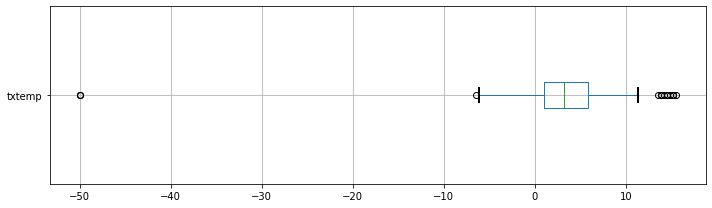

In [241]:
plt.figure(figsize=(10,3))

data.boxplot(column='txtemp', vert=False, capprops=dict(linewidth=2))

plt.tight_layout()
plt.savefig('boxplot_temperatura.png')
plt.show()

In [242]:
#remoção das entradas com temperatura 
data= data[data['txtemp'] > -50]

### Distribuições de frequência 

In [250]:
data.describe()

,batt,curr,txforward2,txcurr,rxcurr,rxdoppler,rxrssi,txreflected,txforward,txtemp,txvoltage,antsB
count,425.000000,425.000000,425.000000,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.0
mean,8.265576,0.065767,11.443538,0.0,0.057678,411.898824,947.265882,0.004274,0.005876,3.519545,8.047400,100.0
std,0.046564,0.001849,17.753440,0.0,0.004059,8.454742,14.341107,0.000991,0.000558,3.971070,0.203344,0.0
min,8.166000,0.063000,0.000000,0.0,0.000000,256.000000,768.000000,0.000000,0.000000,-6.451613,4.129032,100.0
25%,8.286000,0.063000,0.080065,0.0,0.057000,411.000000,944.000000,0.003824,0.005975,0.967742,8.048387,100.0
50%,8.286000,0.067000,0.080065,0.0,0.058000,412.000000,949.000000,0.003824,0.005975,3.225806,8.080645,100.0
75%,8.296000,0.067000,20.496640,0.0,0.058000,414.000000,952.000000,0.003824,0.005975,5.806452,8.096774,100.0
max,8.306000,0.067000,77.115740,0.0,0.061000,429.000000,962.000000,0.005975,0.005975,15.483871,8.129032,100.0


### Correlação

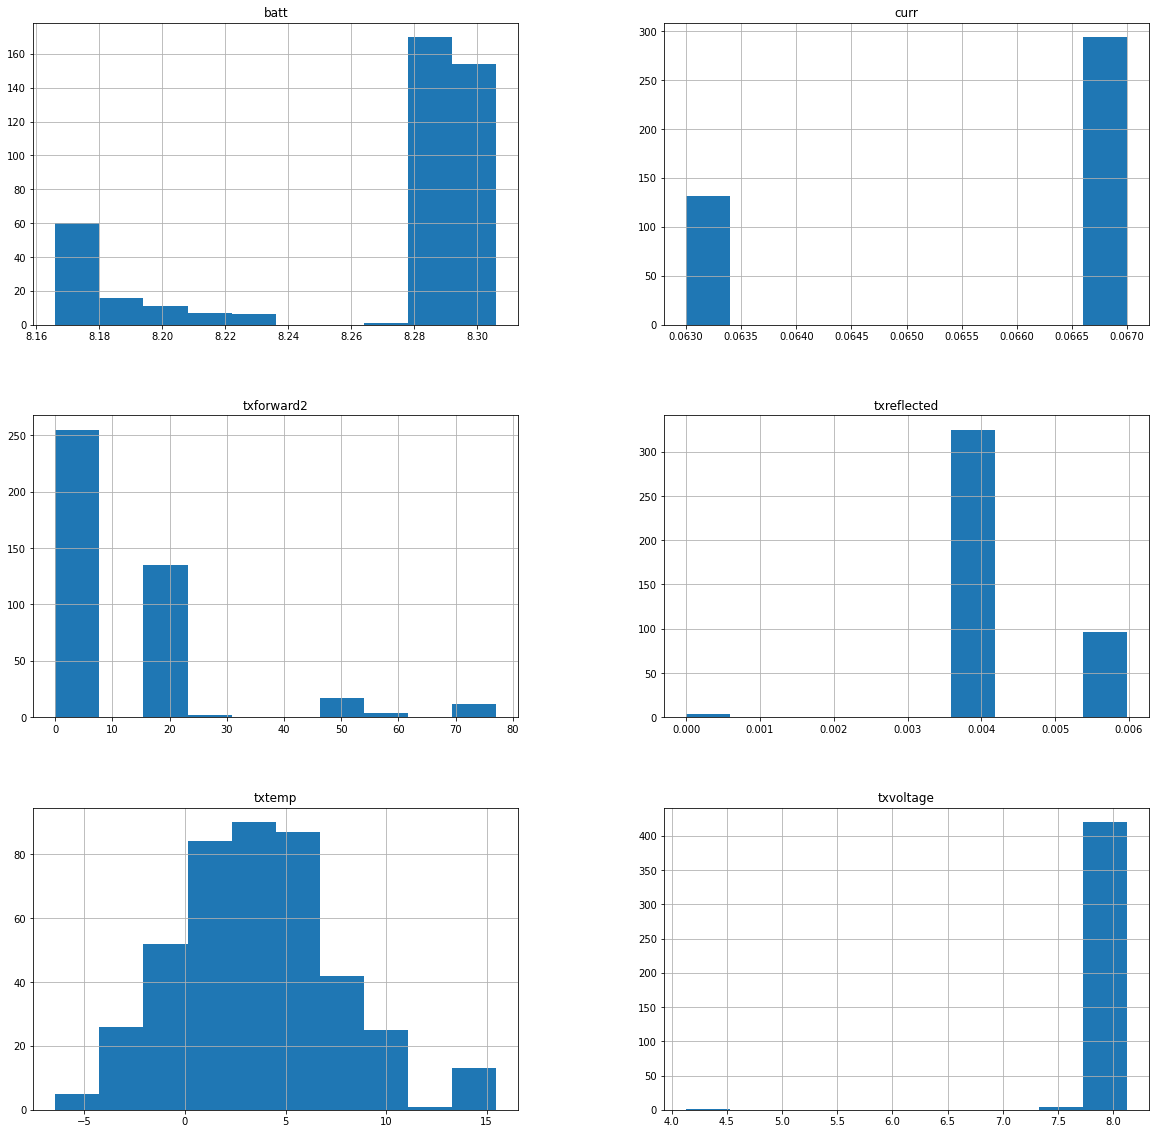

In [251]:
data[['batt',	'curr',	'txforward2', 'txreflected','txtemp','txvoltage']].hist(figsize=(20,20));

In [254]:
#usando Kendall Tau pelo tamanho do conjunto de dados
corr = data.iloc[:, 3:14].drop(['txcurr'],axis=1).corr(method='kendall')
corr

,curr,txforward2,rxcurr,rxdoppler,rxrssi,txreflected,txforward,txtemp,txvoltage
curr,1.000000,0.123791,-0.283693,0.107022,0.058003,0.090227,0.055376,-0.114840,0.358925
txforward2,0.123791,1.000000,-0.036243,0.056707,0.007291,-0.064225,0.263182,-0.105028,-0.032505
rxcurr,-0.283693,-0.036243,1.000000,-0.156710,0.038608,0.182999,-0.036246,0.653172,-0.349606
rxdoppler,0.107022,0.056707,-0.156710,1.000000,-0.074122,0.056136,0.078509,-0.149247,0.099724
rxrssi,0.058003,0.007291,0.038608,-0.074122,1.000000,-0.078187,0.025461,0.022711,0.000695
txreflected,0.090227,-0.064225,0.182999,0.056136,-0.078187,1.000000,-0.013877,0.212345,-0.015292
txforward,0.055376,0.263182,-0.036246,0.078509,0.025461,-0.013877,1.000000,-0.056067,0.010962
txtemp,-0.114840,-0.105028,0.653172,-0.149247,0.022711,0.212345,-0.056067,1.000000,-0.183755
txvoltage,0.358925,-0.032505,-0.349606,0.099724,0.000695,-0.015292,0.010962,-0.183755,1.000000


In [255]:
corr = data.iloc[:, 3:14].drop(['txcurr'],axis=1).corr(method='pearson')
corr

,curr,txforward2,rxcurr,rxdoppler,rxrssi,txreflected,txforward,txtemp,txvoltage
curr,1.000000,0.002492,-0.105853,0.000450,0.014525,0.070832,0.054083,-0.118403,0.099943
txforward2,0.002492,1.000000,0.021895,0.067574,-0.037710,-0.109114,0.105746,-0.163987,0.034602
rxcurr,-0.105853,0.021895,1.000000,-0.027409,-0.002373,0.068342,-0.020340,0.161069,-0.037576
rxdoppler,0.000450,0.067574,-0.027409,1.000000,-0.032709,-0.028588,0.063230,-0.043504,-0.023025
rxrssi,0.014525,-0.037710,-0.002373,-0.032709,1.000000,0.007585,-0.008538,0.040774,-0.018824
txreflected,0.070832,-0.109114,0.068342,-0.028588,0.007585,1.000000,0.001777,0.227379,0.016009
txforward,0.054083,0.105746,-0.020340,0.063230,-0.008538,0.001777,1.000000,-0.054795,-0.005510
txtemp,-0.118403,-0.163987,0.161069,-0.043504,0.040774,0.227379,-0.054795,1.000000,-0.100469
txvoltage,0.099943,0.034602,-0.037576,-0.023025,-0.018824,0.016009,-0.005510,-0.100469,1.000000


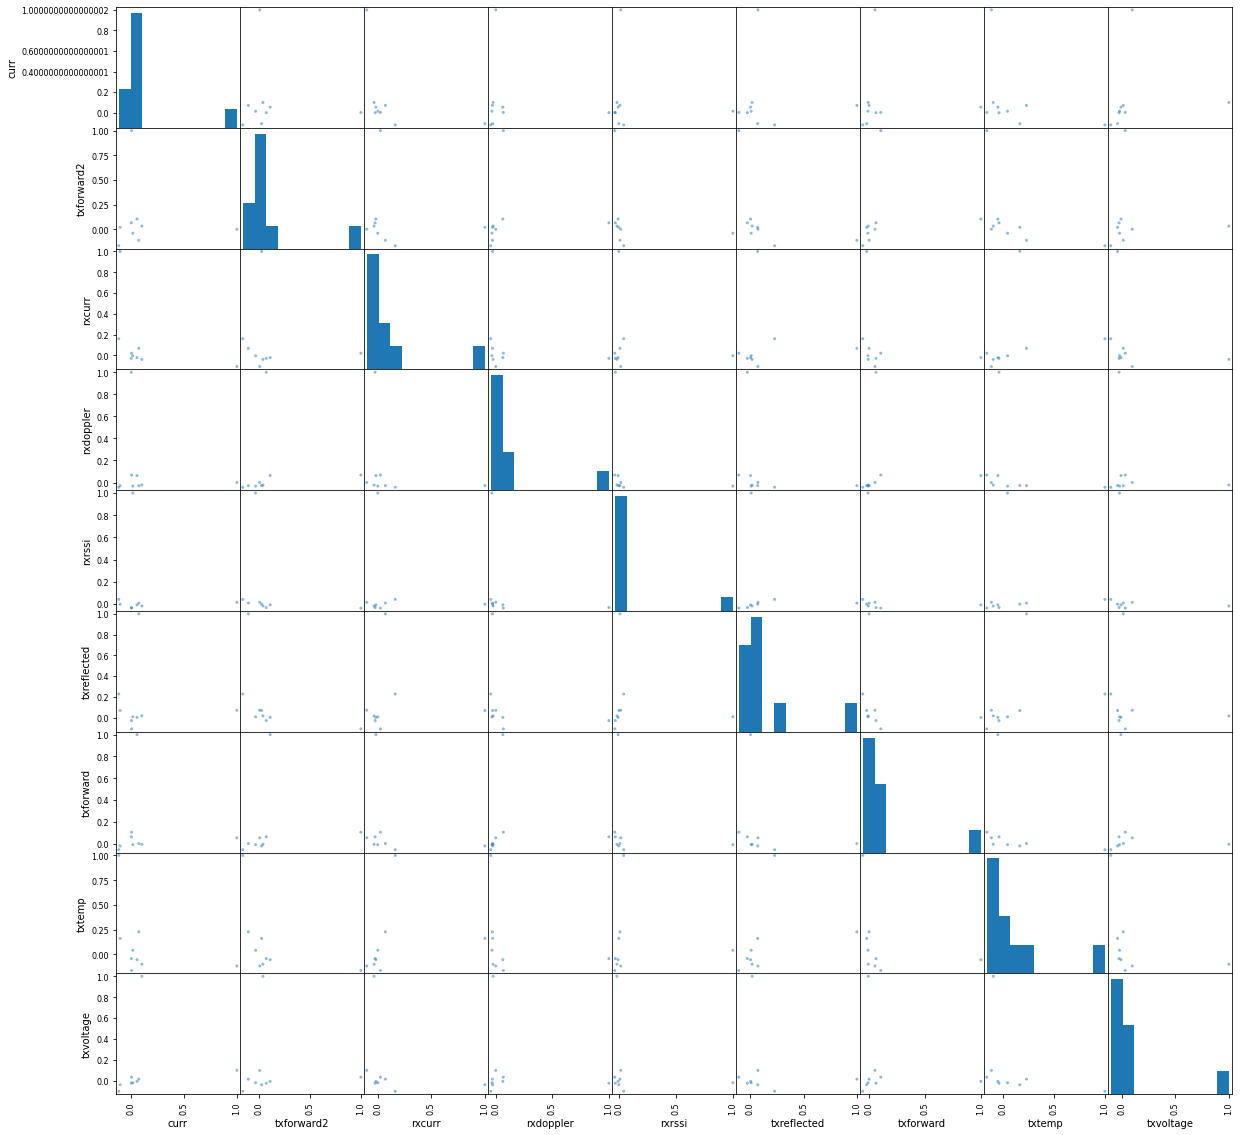

In [256]:
pd.plotting.scatter_matrix(corr, figsize=(20,20));

### Temperatura vs all

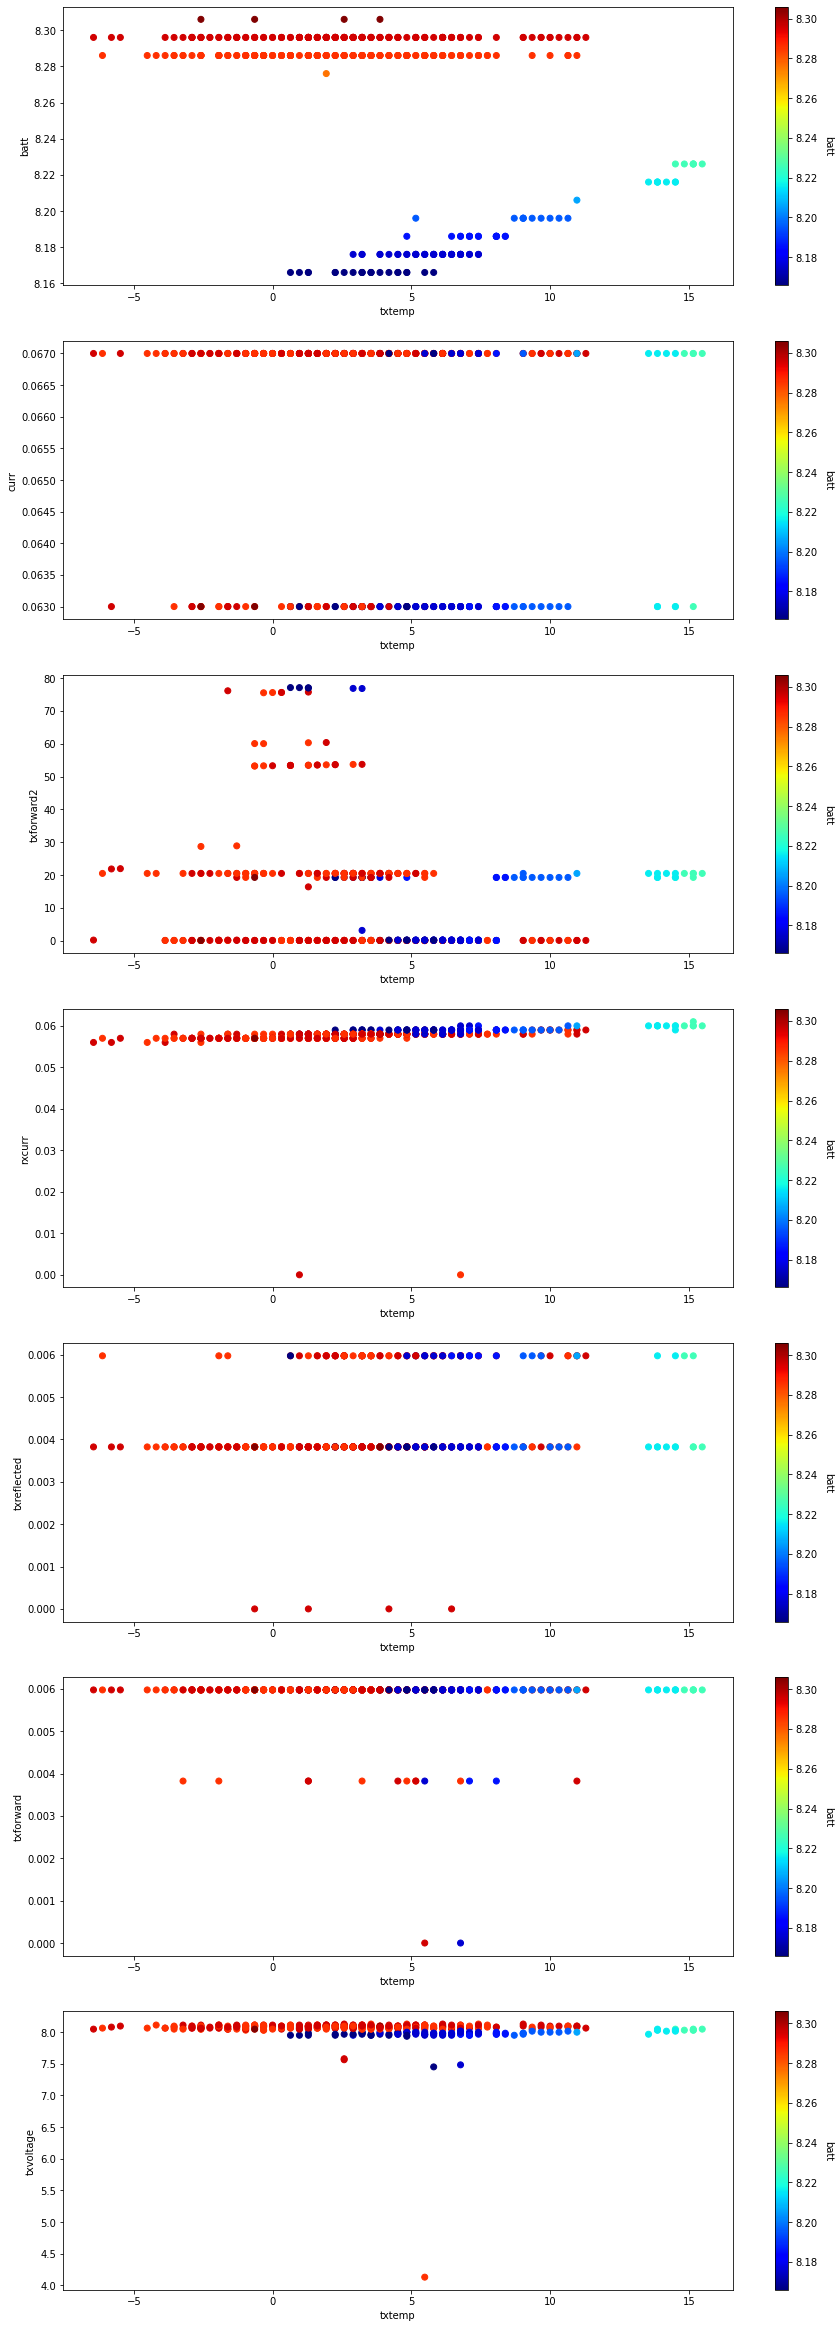

In [257]:
fig, ax = plt.subplots(7,1,figsize=(15,42))
for i, j in zip(['batt', 'curr', 'txforward2', 'rxcurr', 'txreflected', 'txforward', 'txvoltage'], range(7)):
  map = ax[j].scatter(data[data['txtemp']<50]['txtemp'],data[data['txtemp']<50][i],c=data[data['txtemp']<50]['batt'], cmap='jet')
  ax[j].set_xlabel('txtemp')
  ax[j].set_ylabel(i)
  colorbar = fig.colorbar(map, ax=ax[j])
  colorbar.ax.get_yaxis().labelpad = 15
  colorbar.ax.set_ylabel('batt', rotation=270)

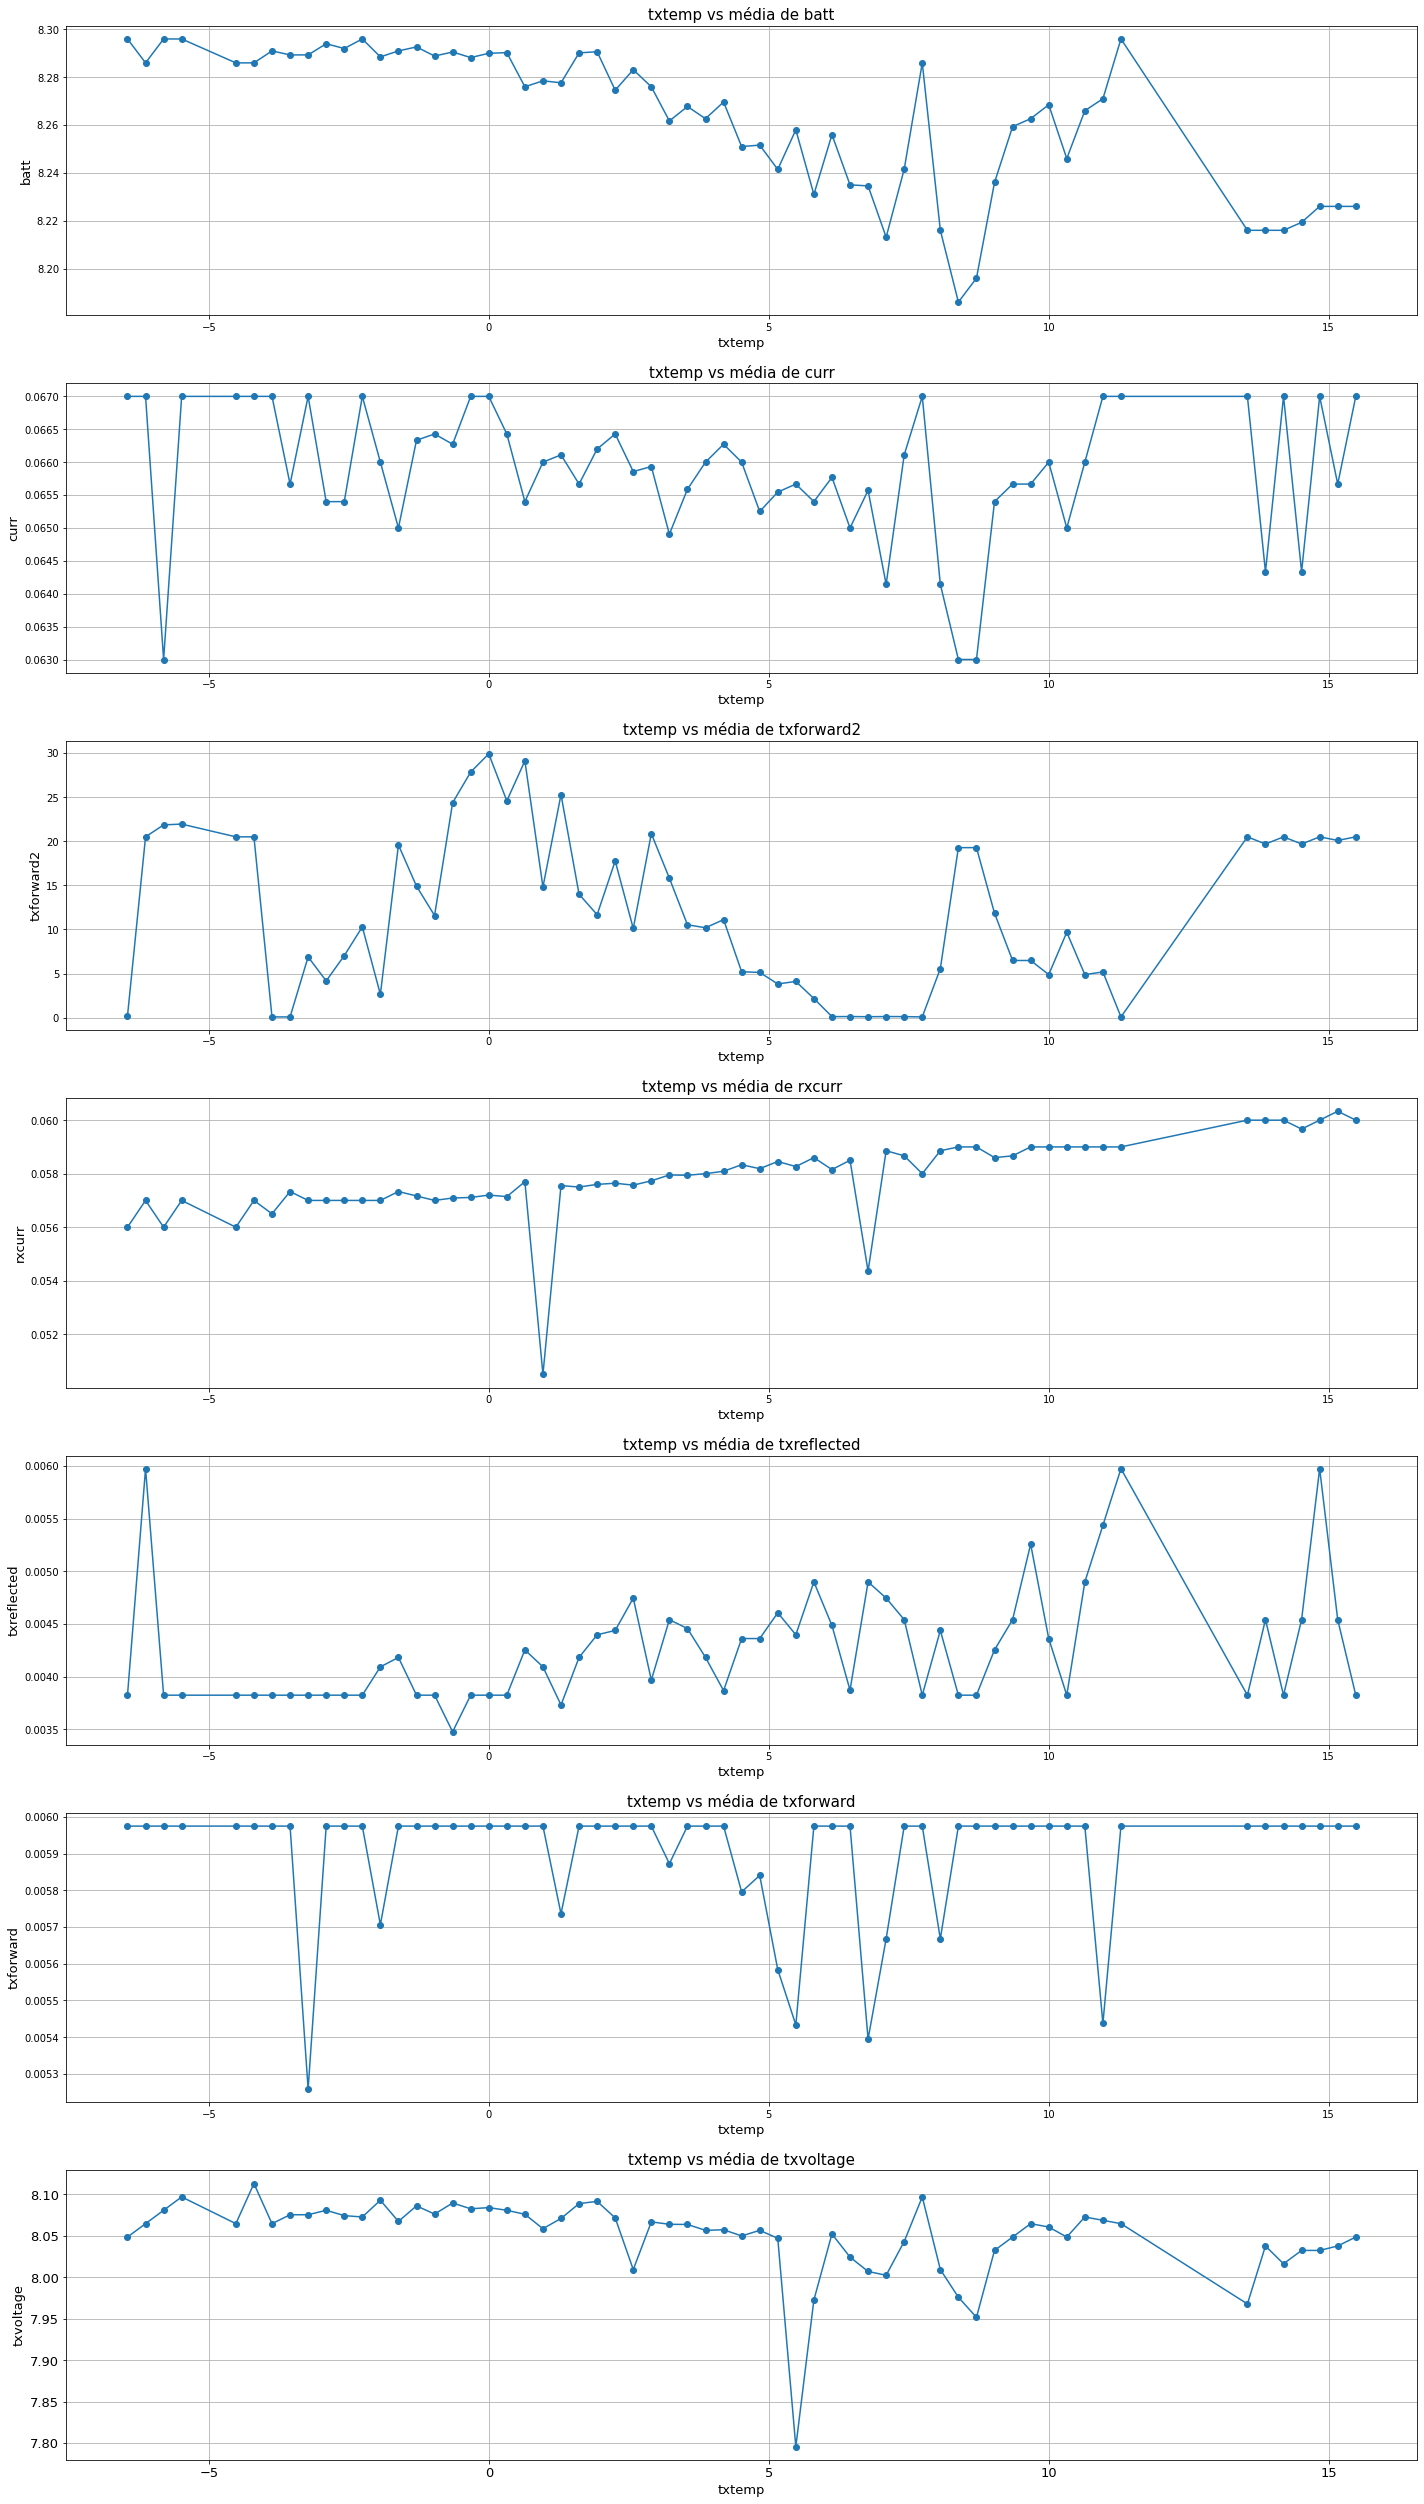

In [258]:
fig, ax = plt.subplots(7,1,figsize=(20,35))
data2 = data.groupby(['txtemp'], as_index=False).mean()
camps = ['batt', 'curr', 'txforward2', 'rxcurr', 'txreflected', 'txforward', 'txvoltage']

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
for i,j in zip(camps, range(7)):
  ax[j].plot(data2['txtemp'],data2[i], marker='o'),ax[j].grid(), ax[j].set_title('txtemp vs média de ' + i, fontsize=15)
  ax[j].set_xlabel('txtemp',fontsize=13)
  ax[j].set_ylabel(i,fontsize=13)
plt.tight_layout(pad=1.5)


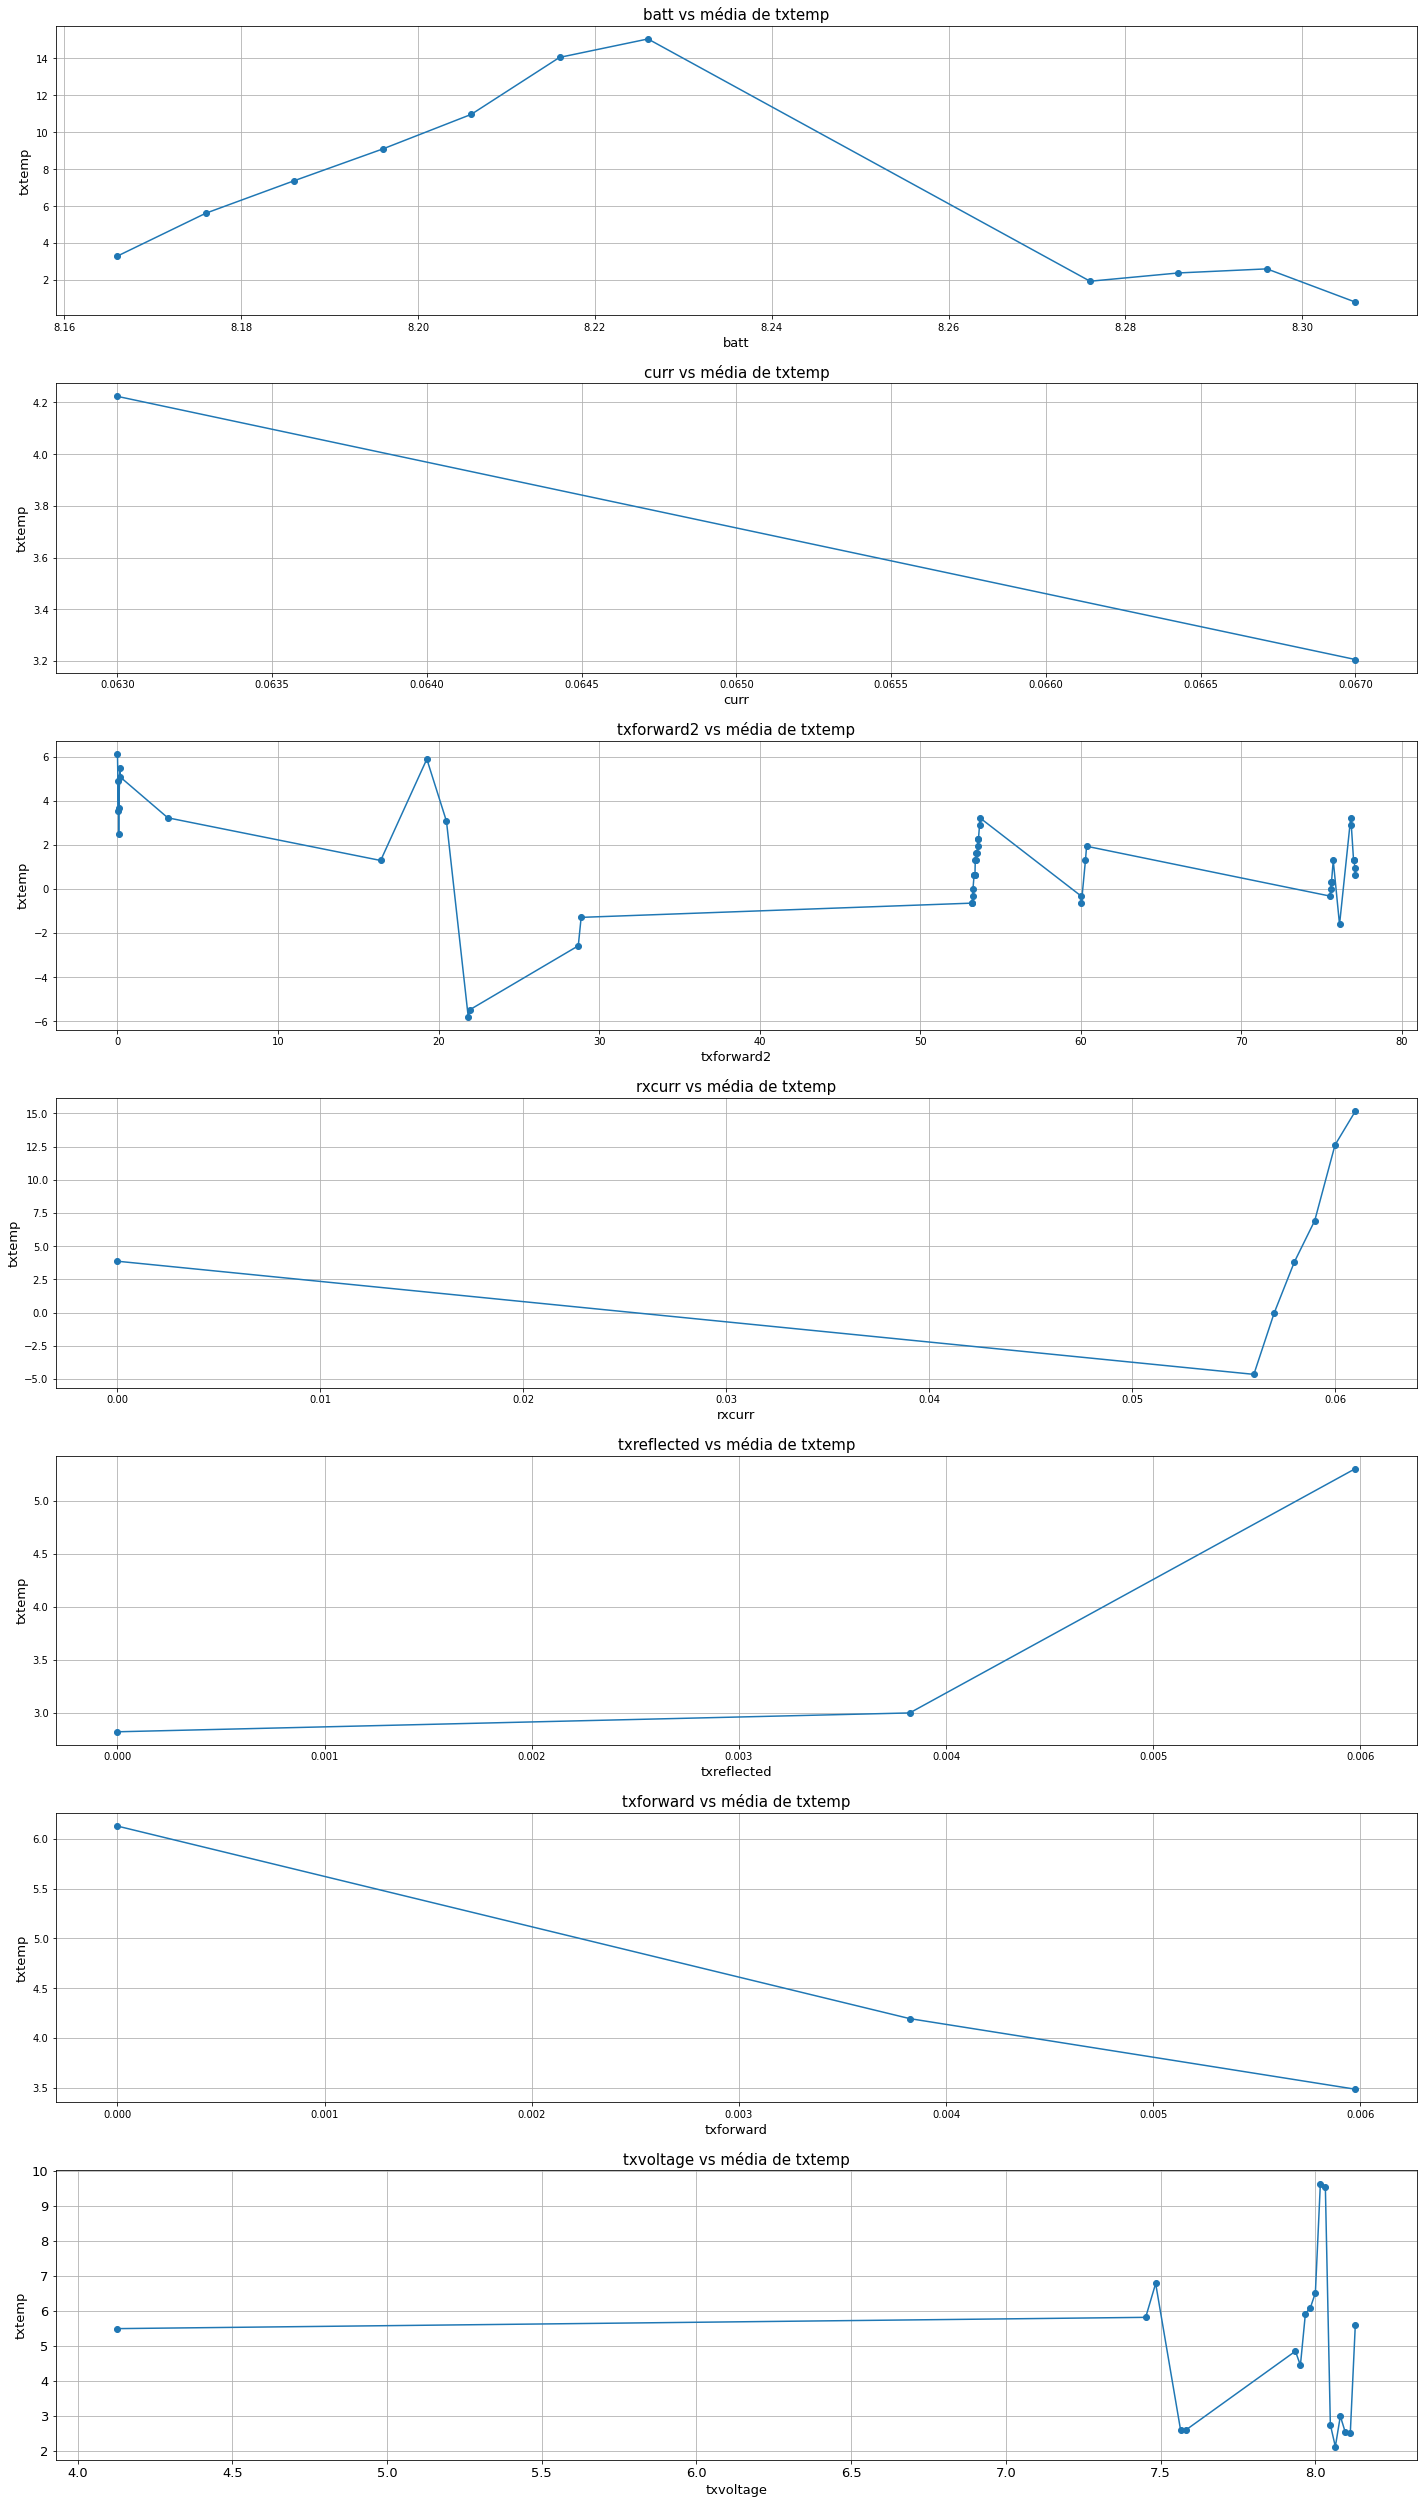

In [259]:
fig, ax = plt.subplots(7,1,figsize=(20,35))
camps = ['batt', 'curr', 'txforward2', 'rxcurr', 'txreflected', 'txforward', 'txvoltage']

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
for i,j in zip(camps, range(7)):
  data2 = data.groupby([i], as_index=False).mean()  
  ax[j].plot(data2[i],data2['txtemp'], marker='o'),ax[j].grid(), ax[j].set_title(i +' vs média de txtemp' , fontsize=15)
  ax[j].set_xlabel(i,fontsize=13)
  ax[j].set_ylabel('txtemp',fontsize=13)
plt.tight_layout(pad=1.5)


### Localização do satélite e plotagens de maneira geospacial


In [262]:
#utiliza os dados do zenodo pois estes contem a longitude e latitude
#usar decimal=',' para especificar para o pandas o separador de decimal
data = pd.read_csv("data/data_from_ncbr2.csv", sep=',')
#removendo dados com erros na leitura
data.drop(data[((data['obcflags'] != '007d')&(data['obcflags'] != '007D'))].index, inplace=True)
#removendo duplicados
data.drop_duplicates(['batt',	'curr',	'txforward2', 'txreflected'	,'txforward'	,'txtemp'	,'txvoltage'], keep='last', inplace=True)
#removendo dados com latitude ou longitude vazios
data = data[data['lon'].notna()]
data = data[data['lat'].notna()]
#formatação do localtime
data['localtime'] = pd.to_datetime(data['localtime'])

In [ ]:
#estações
data['et'].unique()

array(['COESU', 'PY4ZBZ', 'PV8DX', 'K4KDR', 'KB6LTY', 'PY5LF', 'EMMN'],
      dtype=object)

In [ ]:
#numero de registros por estação
data['et'].value_counts()

PV8DX     199
KB6LTY    174
EMMN       53
COESU      50
PY4ZBZ     38
PY5LF      37
K4KDR      13
Name: et, dtype: int64

#### Posições do satélite por estação

Text(0.5, 1.0, 'Posições do NANOSATC-BR2 - Estações')

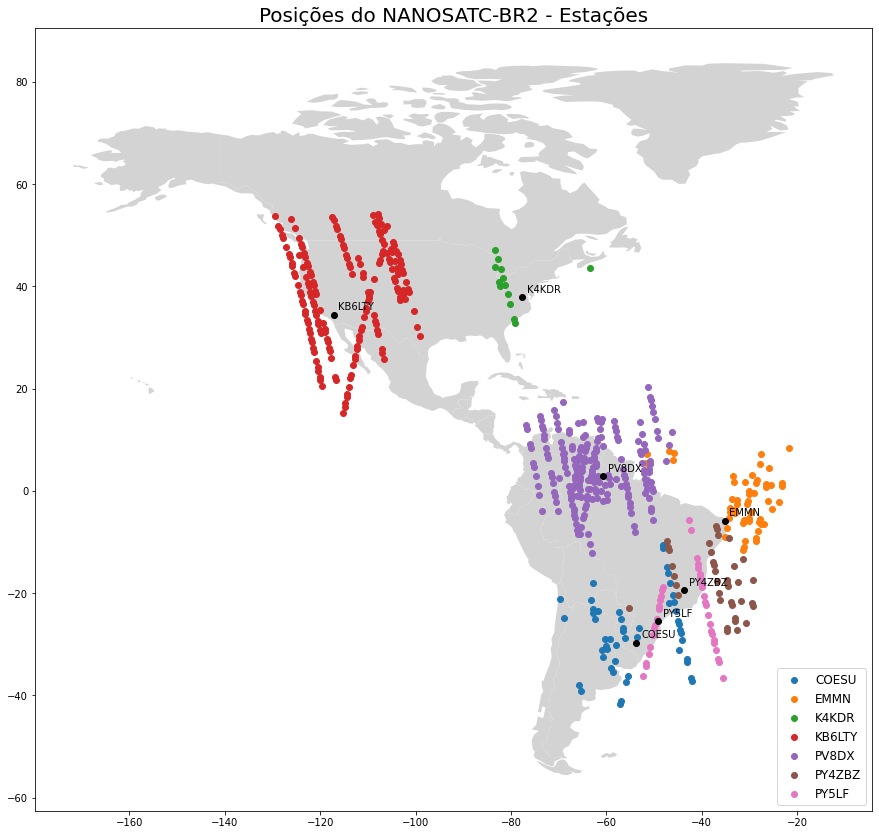

In [139]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
fig, ax = plt.subplots(figsize=(15,15))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.continent == 'North America') | (world.continent == 'South America')]
world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

d = {'lon': [-53.7158, -35.2054, -43.5993, -60.7324, -77.6844, -117.172, -49.2051], 
     'lat': [-29.7219, -5.7957, -19.4227, 2.8113, 37.8215, 34.4275, -25.4732],
     'et': ['COESU', 'EMMN', 'PY4ZBZ', 'PV8DX', 'K4KDR', 'KB6LTY', 'PY5LF']}
stations = pd.DataFrame(d)

for name, group in data[['et', 'lon', 'lat']].groupby(['et']):
  geodf = geopandas.GeoDataFrame(group, crs=CRS.from_epsg(4326), geometry=geopandas.points_from_xy(group['lon'],group['lat']));
  geodf.plot(ax=ax,label=name);

plt.scatter(stations['lon'], stations['lat'], color='black');
for _,i in stations.iterrows():
  ax.annotate(i['et'], (i['lon']+1, i['lat']+1), color='black')

plt.legend(loc='lower right', fontsize=12, frameon=True) 
plt.title('Posições do NANOSATC-BR2 - Estações', fontsize=20)

#### Plotagem geospacial das variaveis

Text(0.5, 1.0, 'Posições do NANOSATC-BR2 - txtemp')

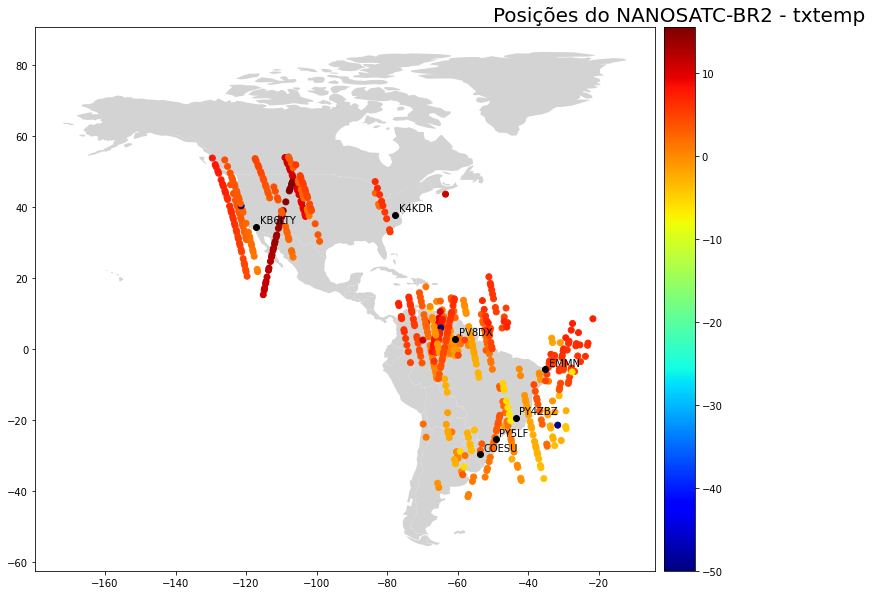

In [137]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(20,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.continent == 'North America') | (world.continent == 'South America')]
world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

d = {'lon': [-53.7158, -35.2054, -43.5993, -60.7324, -77.6844, -117.172, -49.2051], 
     'lat': [-29.7219, -5.7957, -19.4227, 2.8113, 37.8215, 34.4275, -25.4732],
     'et': ['COESU', 'EMMN', 'PY4ZBZ', 'PV8DX', 'K4KDR', 'KB6LTY', 'PY5LF']}
stations = pd.DataFrame(d)

#filtrar por estações
data2 = data#[data['et'] == 'COESU']

column = 'txtemp'

stations = geopandas.GeoDataFrame(stations_pd, crs=CRS.from_epsg(4326), geometry=geopandas.points_from_xy(stations_pd['lon'],stations_pd['lat']));

geodf = geopandas.GeoDataFrame(data2, crs=CRS.from_epsg(4326), geometry=geopandas.points_from_xy(data2['lon'],data2['lat']));
geodf.plot(ax=ax, column=column, cmap='jet', legend=True, cax=cax);

ax.scatter(stations['lon'], stations['lat'], color='black');
for _,i in stations.iterrows():
  ax.annotate(i['et'], (i['lon']+1, i['lat']+1), color='black')

plt.title('Posições do NANOSATC-BR2 - ' + column, fontsize=20)

#### Plotagem dos dias de registro das observações

Text(0.5, 1.0, 'Posições do NANOSATC-BR2 - Agrupados por dia de registro')

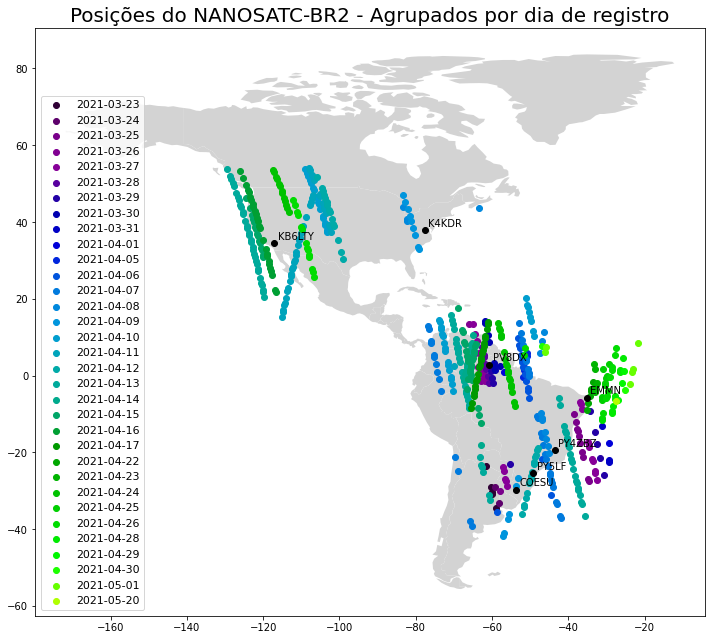

In [141]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,12))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.continent == 'North America') | (world.continent == 'South America')]
world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

d = {'lon': [-53.7158, -35.2054, -43.5993, -60.7324, -77.6844, -117.172, -49.2051], 
     'lat': [-29.7219, -5.7957, -19.4227, 2.8113, 37.8215, 34.4275, -25.4732],
     'et': ['COESU', 'EMMN', 'PY4ZBZ', 'PV8DX', 'K4KDR', 'KB6LTY', 'PY5LF']}
stations = pd.DataFrame(d)

colors = sns.color_palette("nipy_spectral", 50)
ax.set_prop_cycle('color',colors)

for name, group in data[['et', 'lon', 'lat','localtime']].groupby(by=data['localtime'].dt.date):
  geodf = geopandas.GeoDataFrame(group, crs=CRS.from_epsg(4326), geometry=geopandas.points_from_xy(group['lon'],group['lat']));
  geodf.plot(ax=ax,label=name);

ax.scatter(stations['lon'], stations['lat'], color='black');
for _,i in stations.iterrows():
  ax.annotate(i['et'], (i['lon']+1, i['lat']+1), color='black')

ax.legend(loc='lower left',fontsize=11, frameon=True) 
plt.title('Posições do NANOSATC-BR2 - Agrupados por dia de registro', fontsize=20)

#### Plotagem da exposição do satélite ao sol

Text(0.5, 1.0, 'Posições do NANOSATC-BR2 - Estimação da exposição do satélite à luz solar\n através de dados de TLE')

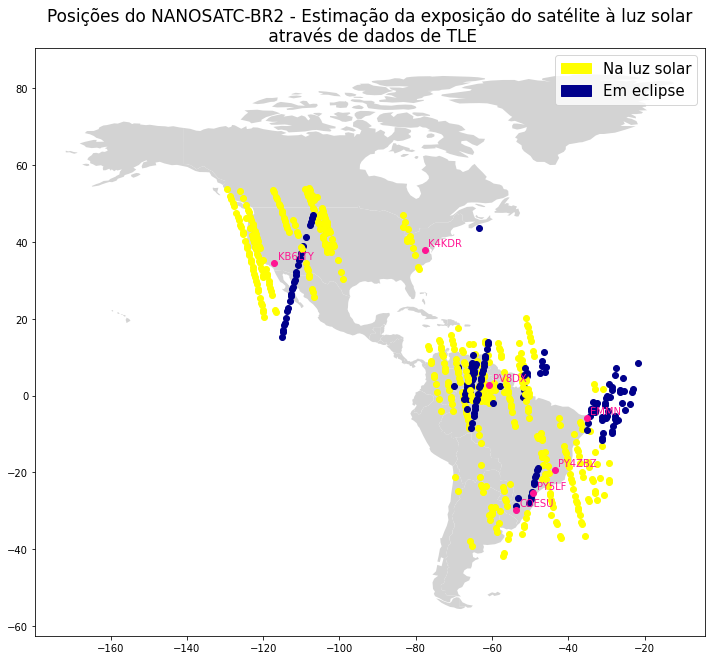

In [265]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
from mpl_toolkits.axes_grid1 import make_axes_locatable

from skyfield.api import load, wgs84
from datetime import datetime
from skyfield.api import utc
from skyfield.api import EarthSatellite

import matplotlib.patches as mpatches

#dados de tle
nanotle = pd.read_csv("data/nanobr2_tle.csv", sep=',')
nanotle = nanotle[['EPOCH', 'TLE_LINE1', 'TLE_LINE2']]
nanotle['EPOCH'] = pd.to_datetime(nanotle['EPOCH'])
#ephemeris para calculo  
eph = load('de421.bsp')
ts = load.timescale()

def nearest(items, pivot):
    return min(items, key=lambda x: abs((x - pivot).total_seconds()) )

satellites = dict()

#criando instancias dos satélites
for i, row in nanotle.iterrows():
  tle1 = row['TLE_LINE1']
  tle2 = row['TLE_LINE2']
  satellite = EarthSatellite(tle1, tle2)  
  satellites[row['EPOCH']] = satellite

fig, ax = plt.subplots(figsize=(12,12))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.continent == 'North America') | (world.continent == 'South America')]
world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

d = {'lon': [-53.7158, -35.2054, -43.5993, -60.7324, -77.6844, -117.172, -49.2051], 
     'lat': [-29.7219, -5.7957, -19.4227, 2.8113, 37.8215, 34.4275, -25.4732],
     'et': ['COESU', 'EMMN', 'PY4ZBZ', 'PV8DX', 'K4KDR', 'KB6LTY', 'PY5LF']}
stations = pd.DataFrame(d)


for i, row in data[['lon', 'lat','localtime']].iterrows():
  satellite = satellites[nearest(satellites, row['localtime'])]

  #plotando com cores de dia/noite
  geodf = geopandas.GeoDataFrame(crs=CRS.from_epsg(4326), geometry=[Point(row['lon'], row['lat'])]);
  geodf.plot(ax=ax, color = ('yellow' if satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc))).is_sunlit(eph) else 'darkblue'));

ax.scatter(stations['lon'], stations['lat'], color='deeppink');
for _,i in stations.iterrows():
  ax.annotate(i['et'], (i['lon']+1, i['lat']+1), color='deeppink')

plt.legend(handles=[mpatches.Patch(color='yellow', label='Na luz solar'), mpatches.Patch(color='darkblue', label='Em eclipse')], fontsize=15)
plt.title('Posições do NANOSATC-BR2 - Estimação da exposição do satélite à luz solar\n através de dados de TLE', fontsize=17)

# Modelos preditivos

## Métodos auxiliares


In [266]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

def get_data(localtime = False):
  #load do csv de treinamento
  data = pd.read_csv("data/cubedesign_train.csv", sep=',', decimal=',')

  #limpeza dos dados
  data.drop(data[((data['obcflags'] != '007d')&(data['obcflags'] != '007D'))].index, inplace=True) #remoção dos dados com flags erradas
  data.drop_duplicates(['batt',	'curr',	'txforward2', 'txreflected'	,'txforward'	,'txtemp'	,'txvoltage'], keep='last', inplace=True)#remoção de duplicatas
  data= data[data['txtemp'] > -50]#remoção de outliers de temperatura

  #load do csv de teste
  data2 = pd.read_csv("data/cubedesign_test.csv", sep=',', decimal=',')
  data2.drop(data2[((data2['obcflags'] != '007d')&(data2['obcflags'] != '007D'))].index, inplace=True)
  data2.drop_duplicates(['batt',	'curr',	'txforward2', 'txreflected'	,'txforward'	,'txtemp'	,'txvoltage'], keep='last', inplace=True)
  data2= data2[data2['txtemp'] > -50]

  #correção dos dados no arquivo csv de teste
  data2['batt'] = data2['batt']/1000.0
  data2['rxcurr'] = data2['rxcurr']/1000.0
  data2['curr'] = data2['curr']/1000.0

  if(localtime):
    X_train = data[['et','txvoltage', 'batt', 'localtime']]
    X_test = data2[['et','txvoltage', 'batt', 'localtime']]
    X_train['localtime'] = pd.to_datetime(data['localtime'], dayfirst=True)
    X_test['localtime'] = pd.to_datetime(data2['localtime'], dayfirst=True)
  else:
    X_train = data[['et','txvoltage', 'batt']]
    X_test = data2[['et','txvoltage', 'batt']]

  y_train = data[['txtemp']]
  y_test = data2[['txtemp']]
  
  
  #usei o OrdinalEnconder para tratar as estações, [1,2,3,4 ...]
  enc = OrdinalEncoder()
  enc.fit(np.asarray(X_train['et'].values).reshape(-1, 1))

  X_train.loc[:,'et'] = enc.transform(np.asarray(X_train['et']).reshape(-1, 1))
  X_test.loc[:,'et'] = enc.transform(np.asarray(X_test['et']).reshape(-1, 1))

  #fazendo a transformação de escala nos dados, primeiro treinando nos dados de trinamento
  #e depois utilizando as mesmas configurações(média, desvio padrão ...) nos dados de teste.
  X_train_copy = X_train.copy()
  X_test_copy = X_test.copy()
  labels = ['txvoltage', 'batt']

  scaler = StandardScaler().fit(X_train.loc[:,labels].values)

  X_train_copy_t = scaler.transform(X_train.loc[:,labels].values)
  X_test_copy_t = scaler.transform(X_test.loc[:,labels].values)

  X_train.loc[:, labels] = X_train_copy_t
  X_test.loc[:, labels] = X_test_copy_t

  return (X_train, y_train, X_test, y_test)

## Modelo com dados originais

R2 treino: 0.6230660102923222
R2 teste: 0.7736879613620727
MAE treino: 1.7482220799552755
MAE teste: 1.9649594898206144
MSE treino: 5.93003455272681
MSE teste: 6.204140446237064


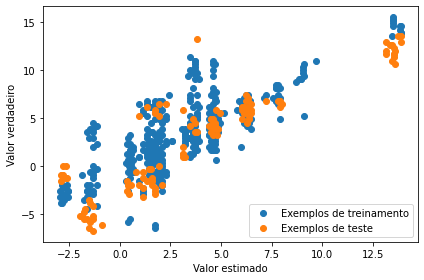

In [267]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

X_train, y_train, X_test, y_test = get_data()

#parametros para o GridSearch
parameters = [
    {"kernel": ["rbf"], "gamma": ['auto'], "C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    {"kernel": ["linear"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    {"kernel": ["poly"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    #{"kernel": ["precomputed"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,1., 0.1))},
    {"kernel": ["sigmoid"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))}
]

#fazendo a busca dos melhores hiperparametros para o modelo SVR
model = SVR()
clf = GridSearchCV(model, parameters)
clf.fit(X_train, np.asarray(y_train).reshape(len(y_train)))

#criando modelo com os melhores hiperparametros encontrados
model.set_params(**clf.best_params_)
model.fit(X_train, np.asarray(y_train).reshape(len(y_train)))

#fazendo predição nos conjuntos de dados de treino e teste
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

#metricas para avaliação
print("R2 treino:", sklearn.metrics.r2_score(y_train, train_predictions))
print("R2 teste:", sklearn.metrics.r2_score(y_test, test_predictions))

print("MAE treino:", mean_absolute_error(y_train, train_predictions))
print("MAE teste:", mean_absolute_error(y_test, test_predictions))

print("MSE treino:", mean_squared_error(y_train, train_predictions))
print("MSE teste:", mean_squared_error(y_test, test_predictions))

#grafico valor estimado vs predição
plt.scatter(train_predictions, y_train, label="Exemplos de treinamento")
plt.scatter(test_predictions, y_test, label="Exemplos de teste")
plt.xlabel("Valor estimado")
plt.ylabel("Valor verdadeiro")
plt.legend()
plt.tight_layout()
plt.show()

## Modelo com dados de luz solar atual

In [268]:
from skyfield.api import load, wgs84
from datetime import datetime
from skyfield.api import utc
from skyfield.api import EarthSatellite

X_train, y_train, X_test, y_test = get_data(localtime=True)

nanotle = pd.read_csv("data/nanobr2_tle.csv", sep=',')
nanotle = nanotle[['EPOCH', 'TLE_LINE1', 'TLE_LINE2']]
nanotle['EPOCH'] = pd.to_datetime(nanotle['EPOCH'])
eph = load('de421.bsp')
ts = load.timescale()

def nearest(items, pivot):
    return min(items, key=lambda x: abs((x - pivot).total_seconds()) )

satellites = dict()
for i, row in nanotle.iterrows():
  tle1 = row['TLE_LINE1']
  tle2 = row['TLE_LINE2']
  satellite = EarthSatellite(tle1, tle2)  
  satellites[row['EPOCH']] = satellite

day = []
for i, row in X_train[['localtime']].iterrows():
  satellite = satellites[nearest(satellites, row['localtime'])]
  day.append(satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc))).is_sunlit(eph))

day_2 = []
for i, row in X_test[['localtime']].iterrows():
  satellite = satellites[nearest(satellites, row['localtime'])]
  day_2.append(satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc))).is_sunlit(eph))

X_train['is_sunlight'] = np.array(day, dtype=int)
X_test['is_sunlight'] = np.array(day_2, dtype=int)
X_train.drop(['localtime'], inplace=True, axis=1)
X_test.drop(['localtime'], inplace=True, axis=1)

R2 treino: 0.623026342049547
R2 teste: 0.7911402559357714
MAE treino: 1.7116021974258708
MAE teste: 1.838322345626414
MSE treino: 5.930658624996031
MSE teste: 5.725701529350468


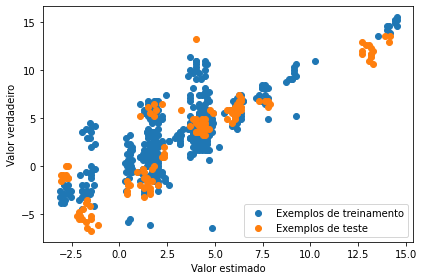

In [269]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


#parametros para o GridSearch
parameters = [
    {"kernel": ["rbf"], "gamma": ['auto'], "C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    {"kernel": ["linear"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    {"kernel": ["poly"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    #{"kernel": ["precomputed"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,1., 0.1))},
    {"kernel": ["sigmoid"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))}
]

#fazendo a busca dos melhores hiperparametros para o modelo SVR
model = SVR()
clf = GridSearchCV(model, parameters)
clf.fit(X_train, np.asarray(y_train).reshape(len(y_train)))

#criando modelo com os melhores hiperparametros encontrados
model.set_params(**clf.best_params_)
model.fit(X_train, np.asarray(y_train).reshape(len(y_train)))

#fazendo predição nos conjuntos de dados de treino e teste
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

#metricas para avaliação
print("R2 treino:", sklearn.metrics.r2_score(y_train, train_predictions))
print("R2 teste:", sklearn.metrics.r2_score(y_test, test_predictions))

print("MAE treino:", mean_absolute_error(y_train, train_predictions))
print("MAE teste:", mean_absolute_error(y_test, test_predictions))

print("MSE treino:", mean_squared_error(y_train, train_predictions))
print("MSE teste:", mean_squared_error(y_test, test_predictions))

#grafico valor estimado vs predição
plt.scatter(train_predictions, y_train, label="Exemplos de treinamento")
plt.scatter(test_predictions, y_test, label="Exemplos de teste")
plt.xlabel("Valor estimado")
plt.ylabel("Valor verdadeiro")
plt.legend()
plt.tight_layout()
plt.show()

##**Modelo entregue** - Modelo com dados de luz solar atual e exposição anterior

In [270]:
from skyfield.api import load, wgs84, Loader
from datetime import datetime, timedelta
from skyfield.api import utc
from skyfield.api import EarthSatellite

X_train, y_train, X_test, y_test = get_data(localtime=True)

nanotle = pd.read_csv("data/nanobr2_tle.csv", sep=',')
nanotle = nanotle[['EPOCH', 'TLE_LINE1', 'TLE_LINE2']]
nanotle['EPOCH'] = pd.to_datetime(nanotle['EPOCH'])
eph = load('de421.bsp')
ts = load.timescale()

def nearest(items, pivot):
    return min(items, key=lambda x: abs((x - pivot).total_seconds()) )

satellites = dict()
for i, row in nanotle.iterrows():
  tle1 = row['TLE_LINE1']
  tle2 = row['TLE_LINE2']
  satellite = EarthSatellite(tle1, tle2)  
  satellites[row['EPOCH']] = satellite

day = []
dayy = []
for i, row in X_train[['localtime']].iterrows():
  satellite = satellites[nearest(satellites, row['localtime'])]
  day.append(satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc))).is_sunlit(eph))
  dayy.append(satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc) - timedelta(minutes=5))).is_sunlit(eph))

day_2 = []
day_22 = []
for i, row in X_test[['localtime']].iterrows():
  satellite = satellites[nearest(satellites, row['localtime'])]
  day_2.append(satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc))).is_sunlit(eph))
  day_22.append(satellite.at(ts.from_datetime(row['localtime'].replace(tzinfo=utc) - timedelta(minutes=5))).is_sunlit(eph))

X_train['is_sunlight'] = np.array(day, dtype=int)
X_test['is_sunlight'] = np.array(day_2, dtype=int)
X_train['was_sunlight'] = np.array(dayy, dtype=int)
X_test['was_sunlight'] = np.array(day_22, dtype=int)
X_train.drop(['localtime'], inplace=True, axis=1)
X_test.drop(['localtime'], inplace=True, axis=1)

R2 treino: 0.617177938120138
R2 teste: 0.794097013924056
MAE treino: 1.713631431220052
MAE teste: 1.7973450125965096
MSE treino: 6.0226674072408874
MSE teste: 5.644644675569041


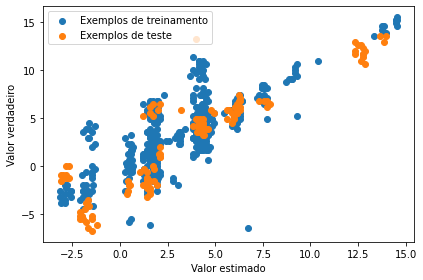

In [185]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


#parametros para o GridSearch
parameters = [
    {"kernel": ["rbf"], "gamma": ['auto'], "C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    {"kernel": ["linear"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    {"kernel": ["poly"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))},
    #{"kernel": ["precomputed"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,1., 0.1))},
    {"kernel": ["sigmoid"], "gamma": ['auto'],"C": list(np.arange(1.,10)), "epsilon": list(np.arange(0.,10., 0.5))}
]

#fazendo a busca dos melhores hiperparametros para o modelo SVR
model = SVR()
clf = GridSearchCV(model, parameters)
clf.fit(X_train, np.asarray(y_train).reshape(len(y_train)))

#criando modelo com os melhores hiperparametros encontrados
model.set_params(**clf.best_params_)
model.fit(X_train, np.asarray(y_train).reshape(len(y_train)))

#fazendo predição nos conjuntos de dados de treino e teste
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

#metricas para avaliação
print("R2 treino:", sklearn.metrics.r2_score(y_train, train_predictions))
print("R2 teste:", sklearn.metrics.r2_score(y_test, test_predictions))

print("MAE treino:", mean_absolute_error(y_train, train_predictions))
print("MAE teste:", mean_absolute_error(y_test, test_predictions))

print("MSE treino:", mean_squared_error(y_train, train_predictions))
print("MSE teste:", mean_squared_error(y_test, test_predictions))

#grafico valor estimado vs predição
plt.scatter(train_predictions, y_train, label="Exemplos de treinamento")
plt.scatter(test_predictions, y_test, label="Exemplos de teste")
plt.xlabel("Valor estimado")
plt.ylabel("Valor verdadeiro")
plt.legend()
plt.tight_layout()
plt.show()

In [86]:
test_file = pd.read_csv("data/cubedesign_test.csv", sep=',', decimal=',')
sample_file = pd.read_csv("data/cubedesign_sample2.csv", sep=',', decimal=',')

sample_file['Predicted'] = model.predict(X_test)
sample_file.to_csv('cubedesign_sample2.csv', index=False)

# Relação temperatura x frequência

## Utilizando simples modelo de regressão

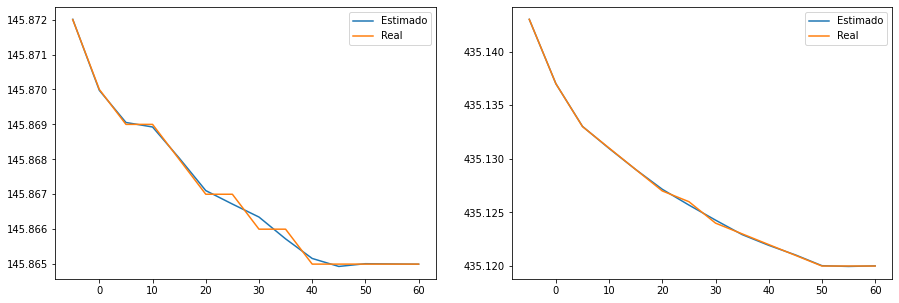

In [271]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

fig, ax = plt.subplots(1,2, figsize=(15,5))

temp = np.arange(-5,65,5)
transmissor_freq = np.array([145.872, 145.870, 145.869, 145.869, 145.868, 145.867, 145.867,
                              145.866, 145.866, 145.865, 145.865, 145.865, 145.865, 145.865])
receptor_freq = np.array([435.143, 435.137, 435.133, 435.131, 435.129, 435.127, 435.126,
                           435.124, 435.123, 435.122, 435.121, 435.120, 435.120, 435.120])

#modelo para frequencia de transmissão
model_trans_freq = make_pipeline(SplineTransformer(n_knots=8,degree=4),Ridge(alpha=1e-5))
model_trans_freq.fit(temp.reshape(-1,1), transmissor_freq)
y_plot_1 = model_trans_freq.predict(temp.reshape(-1,1))

#modelo para frequencia de recepção
model_rec_freq = make_pipeline(SplineTransformer(n_knots=8,degree=4),Ridge(alpha=1e-5))
model_rec_freq.fit(temp.reshape(-1,1), receptor_freq)
y_plot_2 = model_rec_freq.predict(temp.reshape(-1,1))

ax[0].ticklabel_format(useOffset=False)
ax[0].plot(temp, y_plot, label='Estimado')
ax[0].plot(temp, transmissor_freq, label='Real')
ax[0].legend()

ax[1].ticklabel_format(useOffset=False)
ax[1].plot(temp, y_plot_2, label='Estimado')
ax[1].plot(temp, receptor_freq, label='Real')
ax[1].legend()